In [1]:
import pandas as pd
import numpy as np

In [2]:
#M, avgMSR, maxMSR, OHS, OHK, OHS+OHK, topHs, topHk
optimal=np.loadtxt("avgMSR_maxMSR_optH_topH.d")

In [3]:
rats=[20382,24101,21012,22295,20630,22098,23783,24116]
path="../data_gen/"
df = pd.DataFrame()

In [4]:
for i in range(len(rats)):
    ratid=rats[i]
    data=pd.read_json(path+"Rat_"+str(ratid)+"_resrel_data.json",orient="records")
    #print(data.columns)
    data['LOC']=data['LOC'].apply(lambda x: x[-1])
    data['PInfo']=data['PInfo'].apply(lambda x: x['content'])
    data['HInfo']=data['HInfo'].apply(lambda x: x['content'])

    data['poss_PInfo']=data['poss_PInfo'].apply(lambda x: x['content'])
    data['poss_HInfo']=data['poss_HInfo'].apply(lambda x: x['content'])

    # Grouping and calculating mean or sum for specified columns based on group size
    grouped_df = data.groupby('NeuID')
    columns_to_mean = ['Nspikes', 'MSR', 'MHK','MHS','dt_MHK', 'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo','poss_MSR', 'poss_MHK','poss_MHS','poss_dt_MHK', 'poss_OHK', 'poss_OHS','poss_dt_OHK', 'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo']
    tmp_df = pd.DataFrame()
    for name, group in grouped_df:
        if len(group) > 1:
            result_values = group[columns_to_mean].mean()
        else:
            result_values = group[columns_to_mean].sum()
        tmp_df = pd.concat([tmp_df, result_values.to_frame(name=name).T])
    tmp_df['RatID'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['RAT_ID'])
    tmp_df['LOC'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['LOC'])
    tmp_df['task'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['task'])
    columns = tmp_df.columns.tolist()
    tmp_df=tmp_df[ columns[-3:] + columns[:-3]]
    tmp_df.reset_index(inplace=True)
    tmp_df.rename(columns={'index': 'NeuID'}, inplace=True)
    #print(df.columns)
    df = pd.concat([df,tmp_df], ignore_index=True)


In [5]:
df.columns

Index(['NeuID', 'RatID', 'LOC', 'task', 'Nspikes', 'MSR', 'MHK', 'MHS',
       'dt_MHK', 'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo',
       'poss_MSR', 'poss_MHK', 'poss_MHS', 'poss_dt_MHK', 'poss_OHK',
       'poss_OHS', 'poss_dt_OHK', 'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo'],
      dtype='object')

In [6]:
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update(mpl.rcParamsDefault)

In [7]:
mss=120
fontssize=50
mpl.rcParams.update({
    'figure.figsize': (23.6,12.6),
    'font.family': 'serif',
    'font.serif': ['Liberation Sans'],  # Add or remove font names as needed
    'font.size': fontssize,  # Adjust as needed
    #'font.weight': 'bold',
    "svg.fonttype": 'none',
    'text.usetex': False,
    'axes.linewidth' : 2,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{cmbright}',
    'xtick.labelsize' : fontssize, # fontsize of the x tick labels
    'ytick.labelsize' : fontssize # fontsize of the y tick labels
})
ticks_font = font_manager.FontProperties(family='Liberation Sans', style='normal',
    size=fontssize, weight='bold', stretch='normal')
tf = {}


In the Optimal values files these rows represent the measures


Number of spikes-0, poss_MSR_opt-1,MSR-2,MHK-6,OHK-4,OHS-3,OHK+OHS-5

plot for MSR

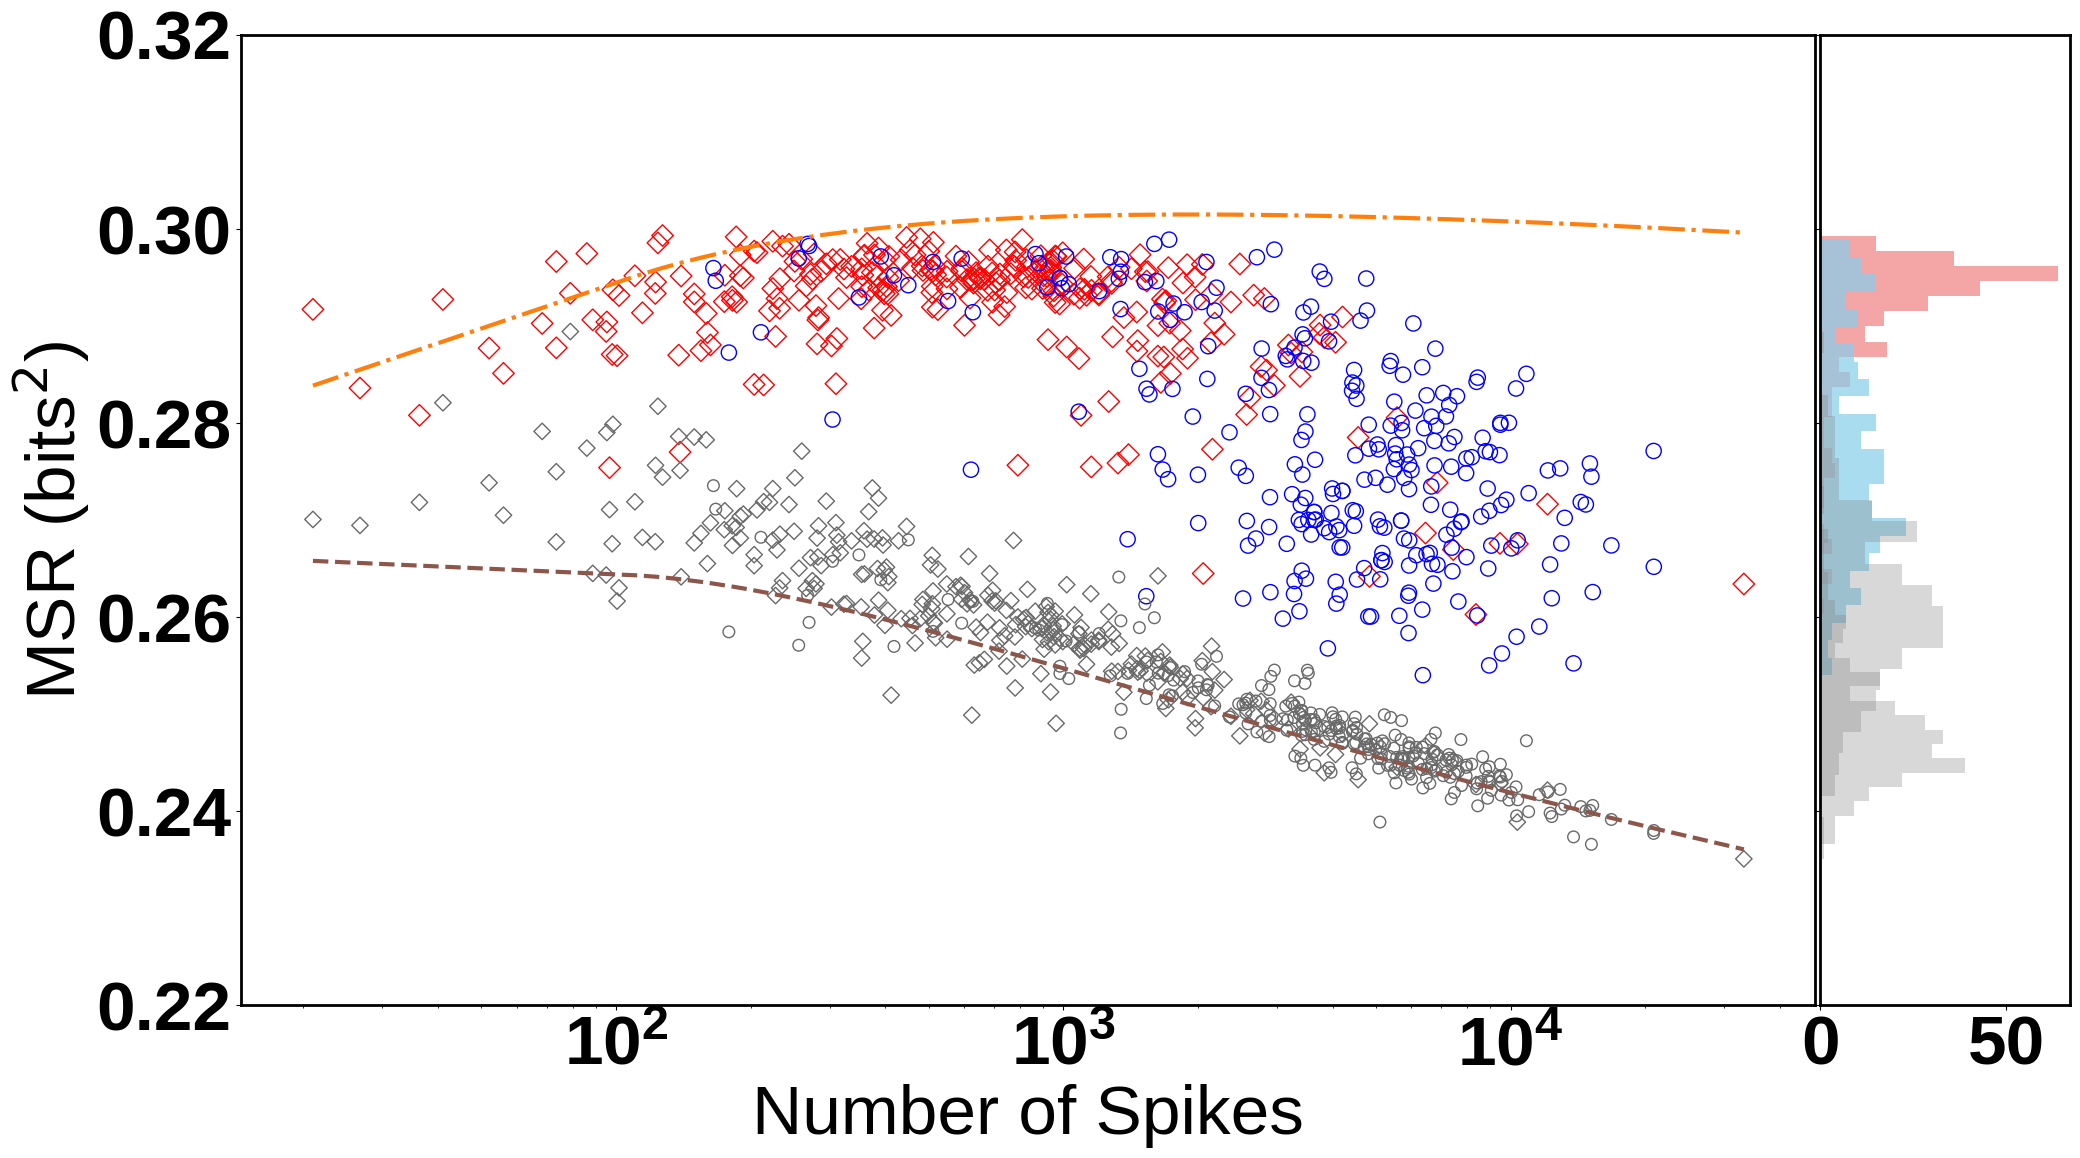

In [8]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MSR'
quant_lab=r'MSR (bits$^2$)'
figname='../figures/MSRvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1A.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,2],fill_value="extrapolate")
msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal MSR
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_ylim(0.22,0.32)
ax.set_xscale('log');
for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)

# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.17), ncol=3,fontsize=22)

# fig.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
# plt.savefig(figname2,dpi=300)
plt.show(fig)

In the Optimal values files these rows represent the measures


Number of spikes-0, poss_MSR_opt-1,MSR-2,MHK-6,OHK-4,OHS-3,OHK+OHS-5

Plot for the relevance quantities

Optimal

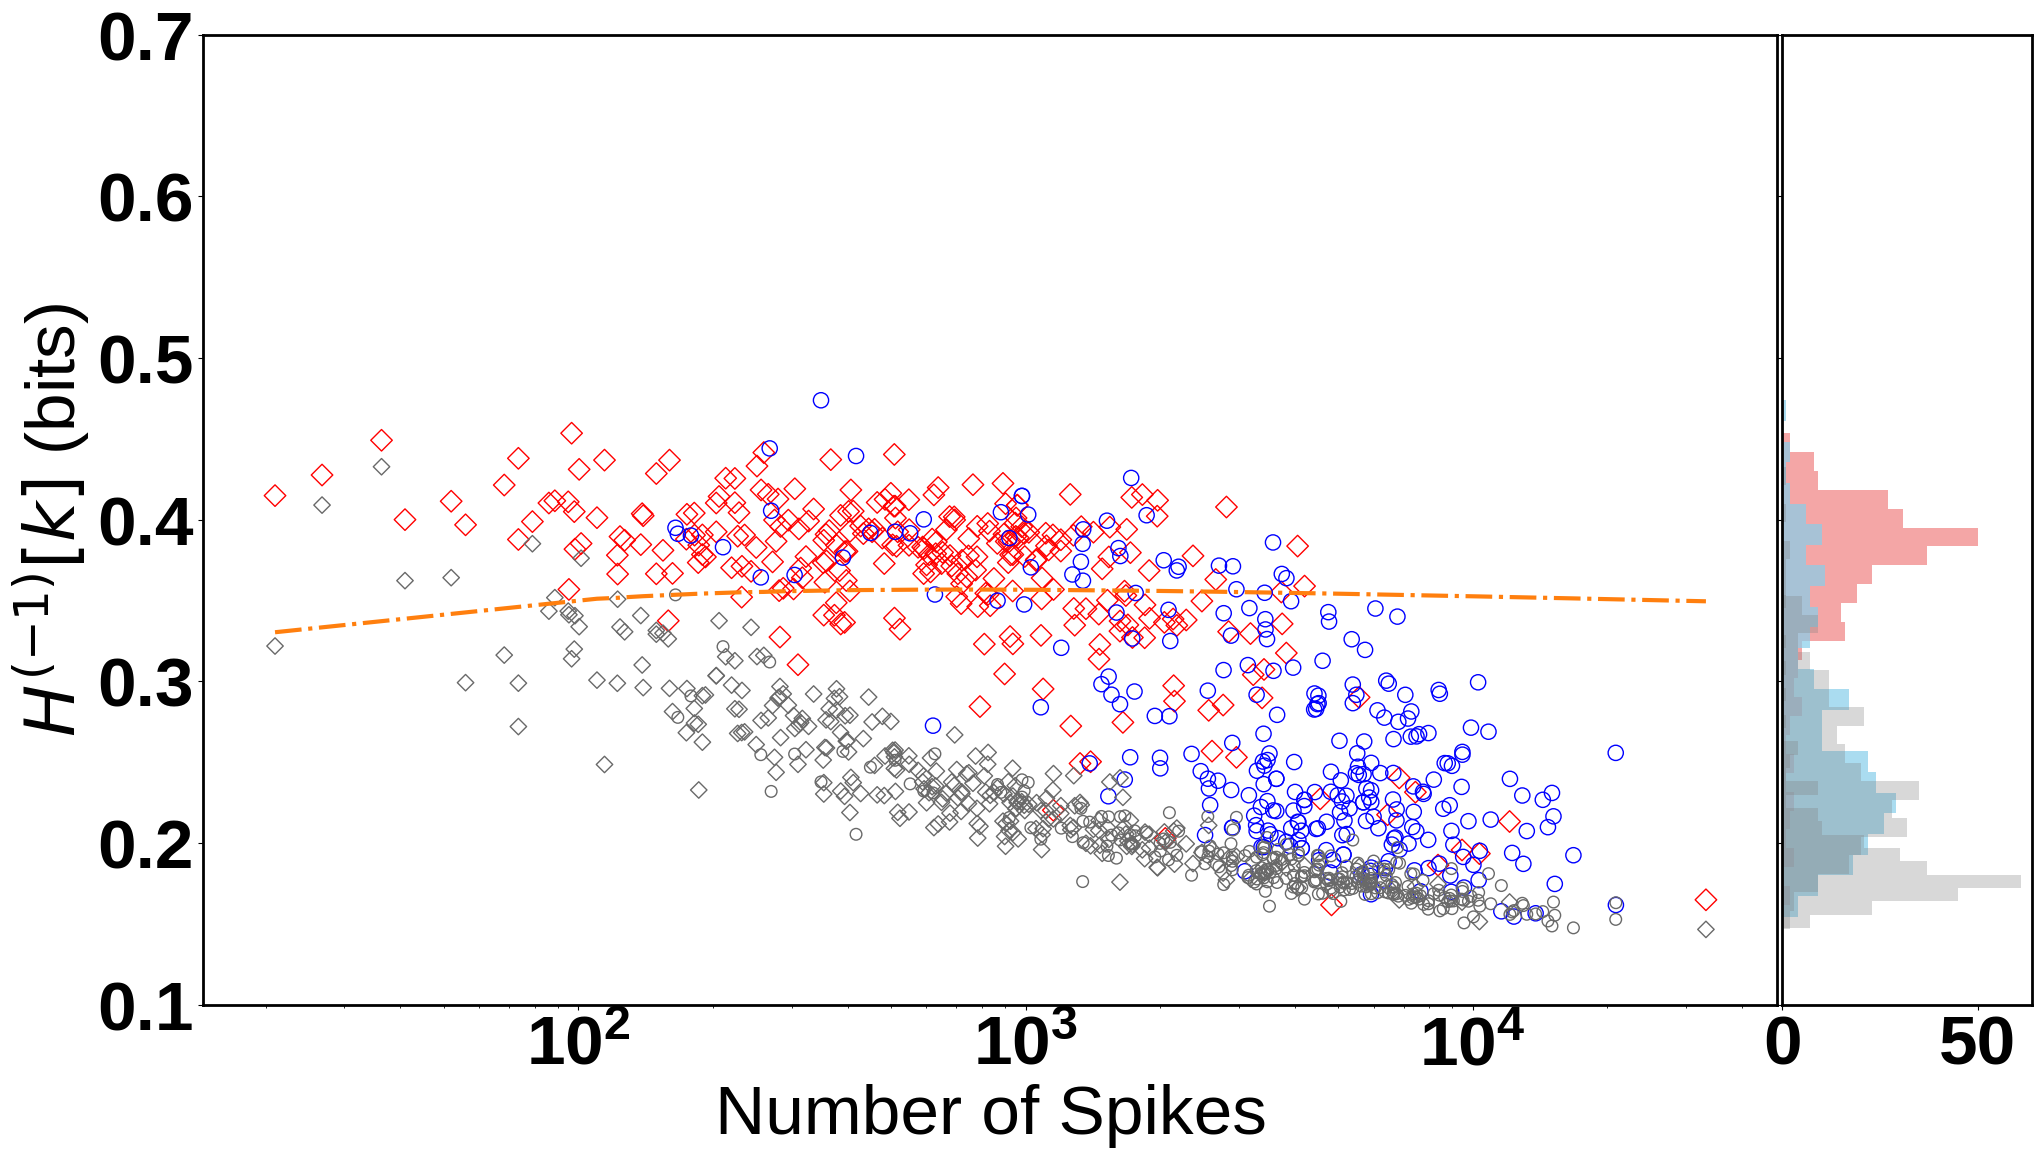

In [9]:
# Create scatter plot
fig, ax = plt.subplots()
quant='OHK'
quant_lab=r'$H^{(-1)}[k]$ (bits)'
figname='../figures/OHKvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,4],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.1, 0.7)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

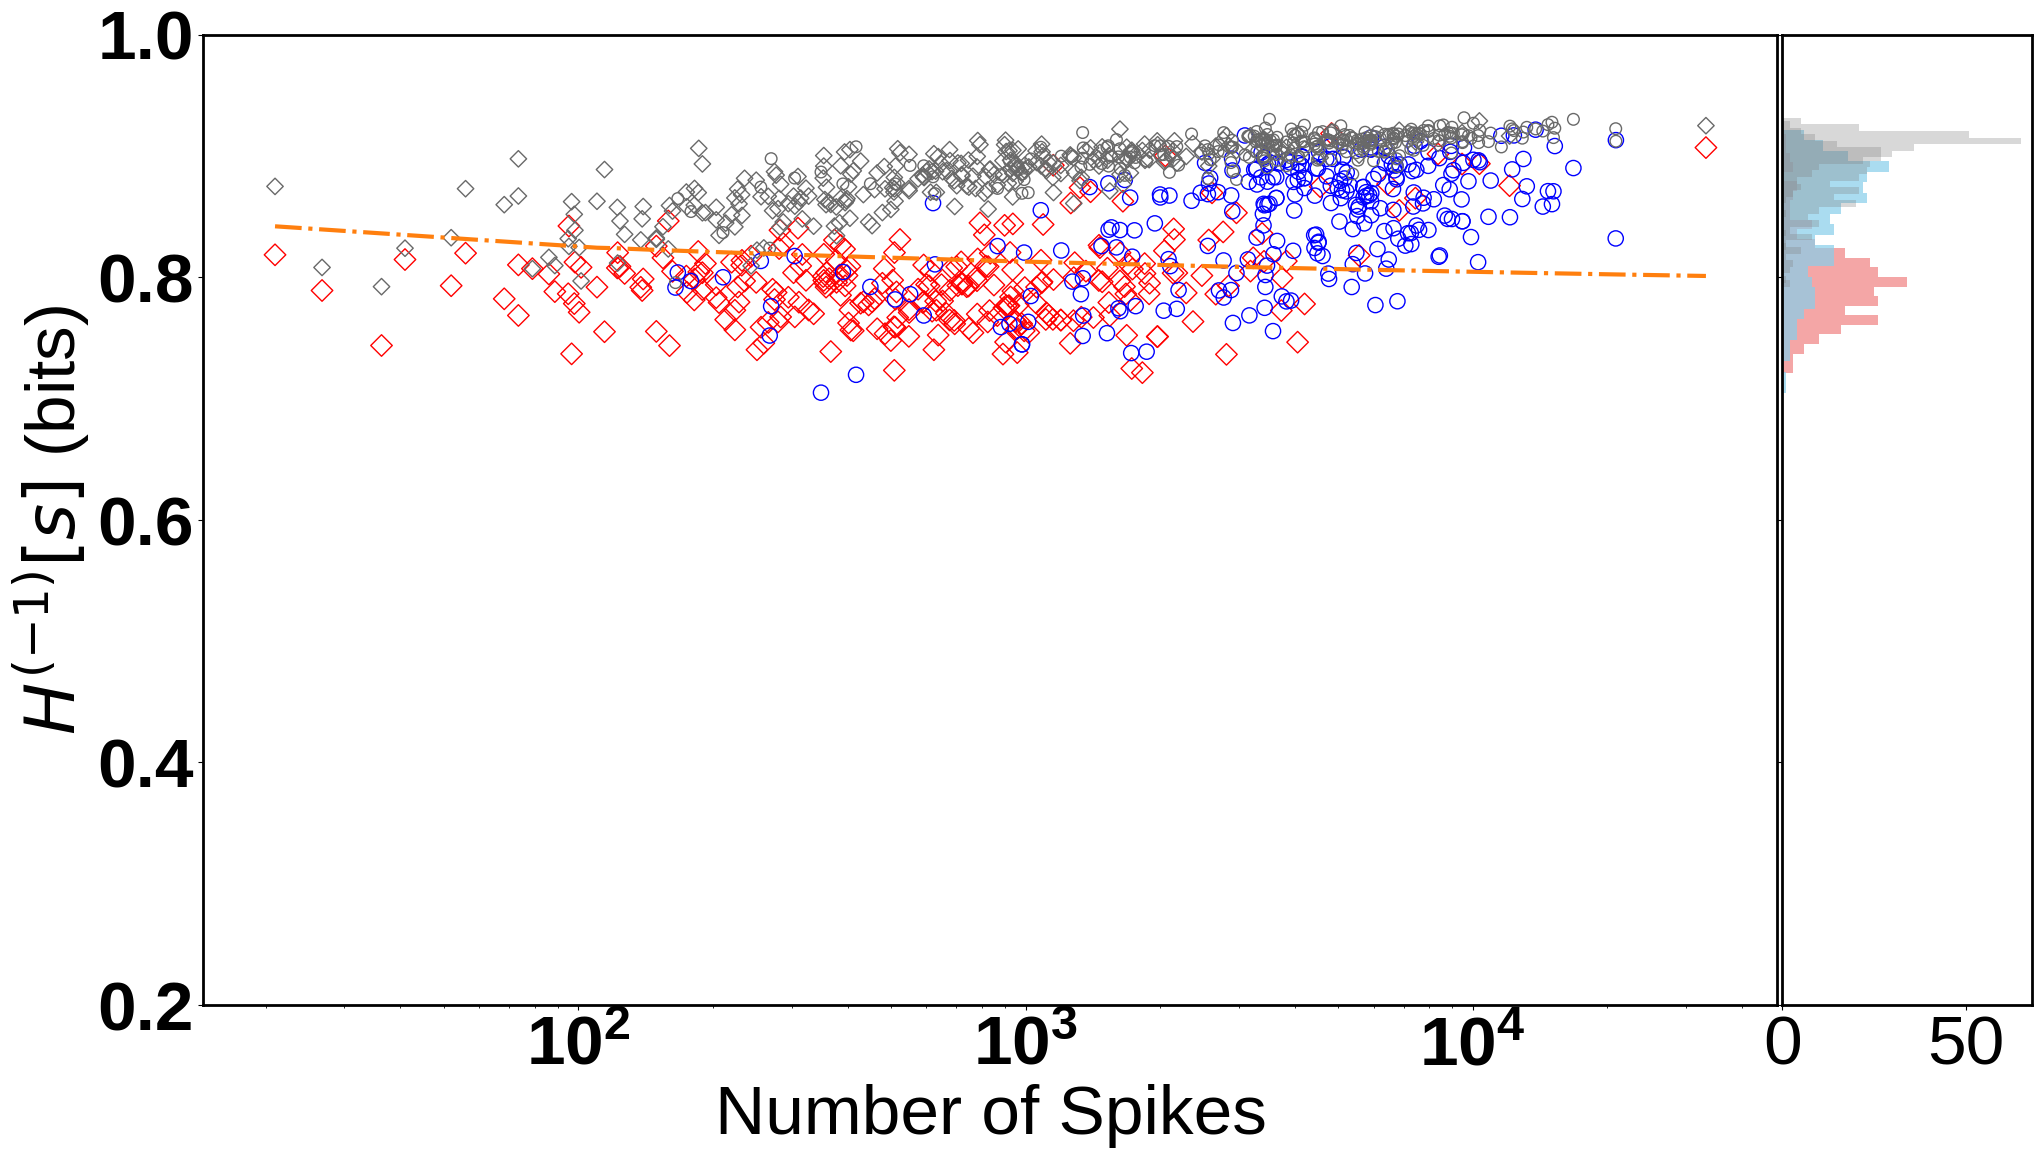

In [10]:
# Create scatter plot
fig, ax = plt.subplots()
quant='OHS'
quant_lab=r'$H^{(-1)}[s]$ (bits)'
figname='../figures/OHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,3],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.2, 1)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
fig.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

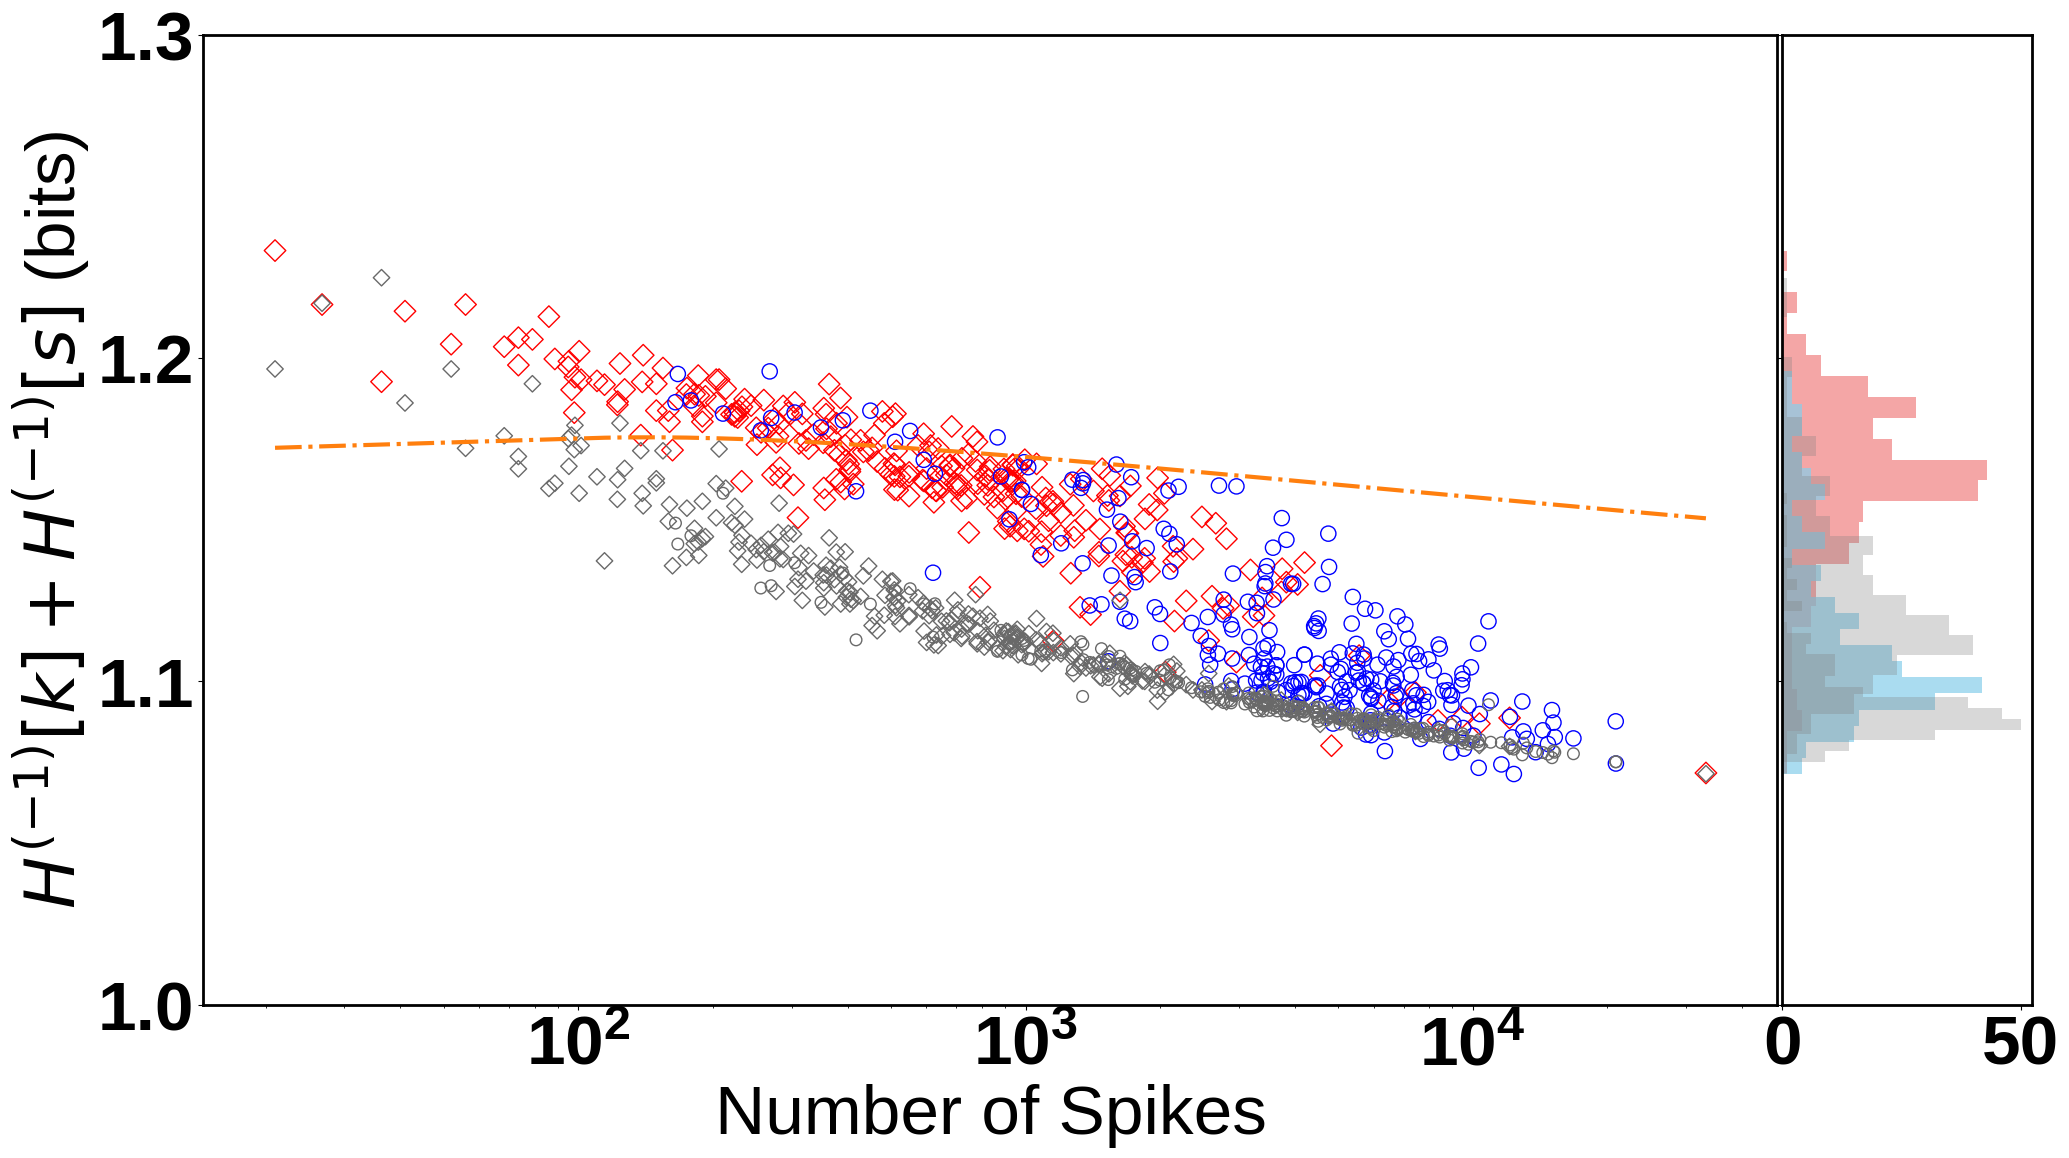

In [11]:
# Create scatter plot
fig, ax = plt.subplots()
quant='max_HSHK'
quant_lab=r'$H^{(-1)}[k] + H^{(-1)}[s]$ (bits)'
figname='../figures/OHKHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,5],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(1, 1.3)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

Maximal

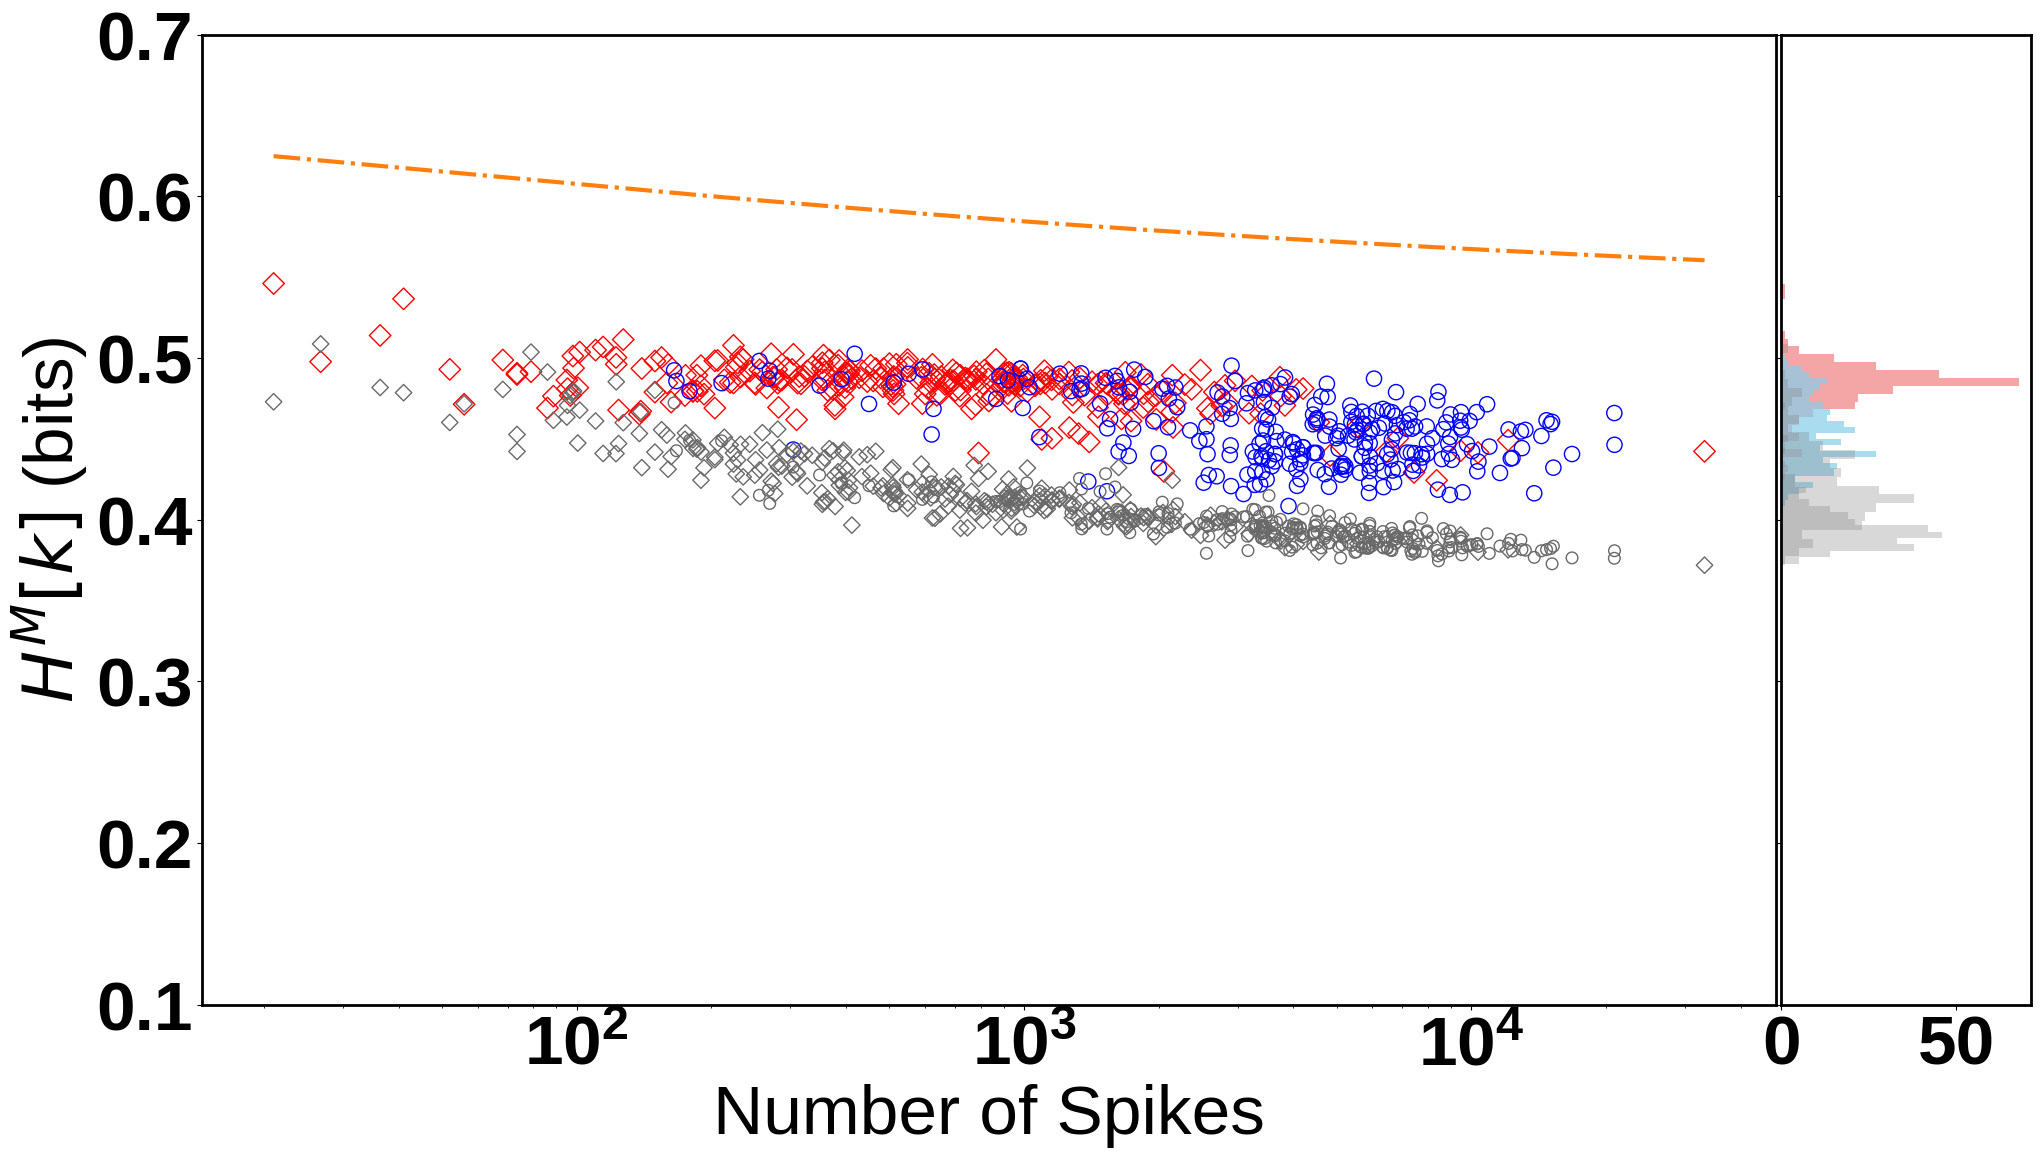

In [12]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MHK'
quant_lab=r'$H^M[k]$ (bits)'
figname='../figures/MHKvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.1, 0.7)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

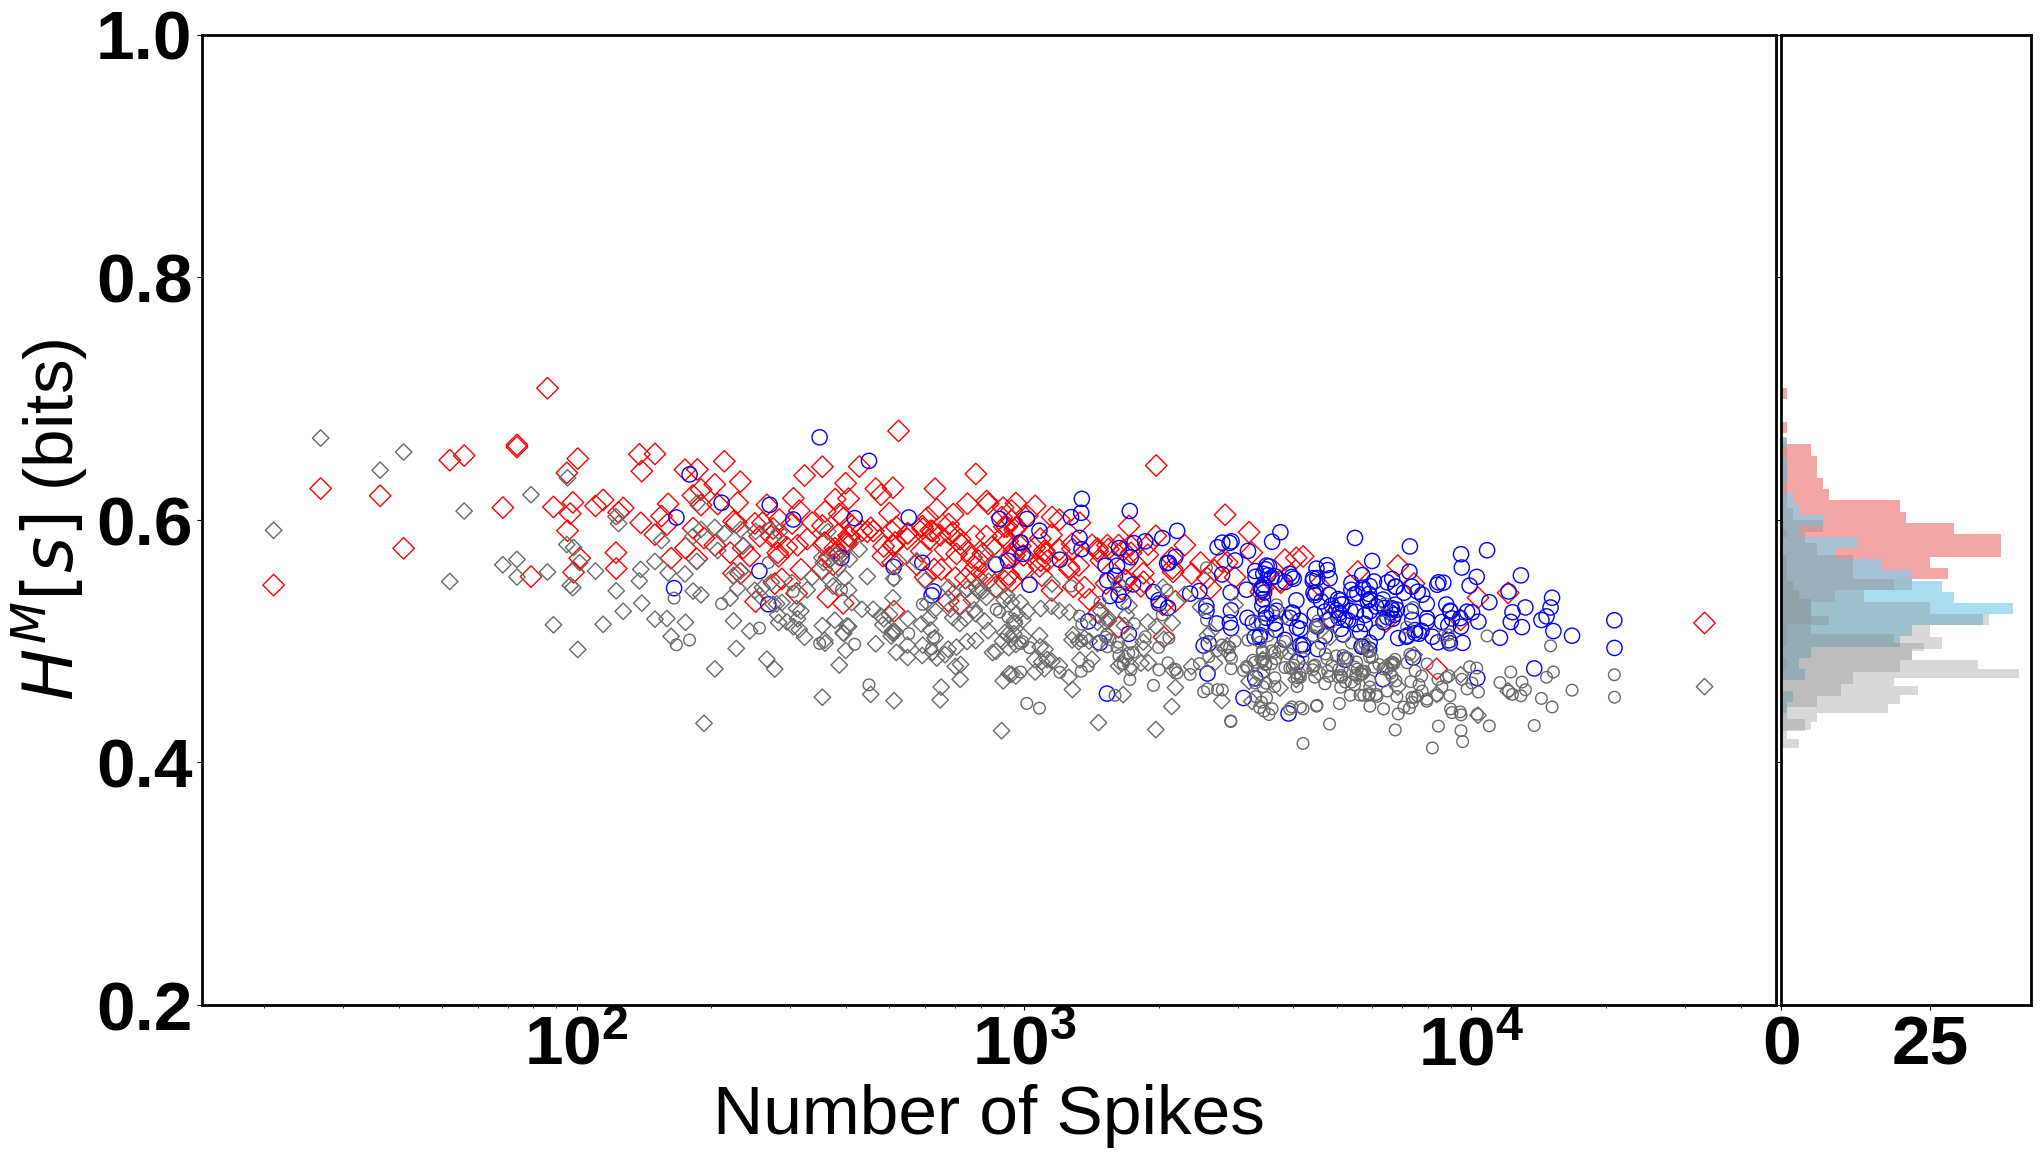

In [13]:
# Create scatter plot
fig, ax = plt.subplots()
quant='MHS'
quant_lab=r'$H^M[s]$ (bits)'
figname='../figures/MHSvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

#msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
# ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');
ax.set_ylim(0.2, 1.0)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

Plots for the optimal time

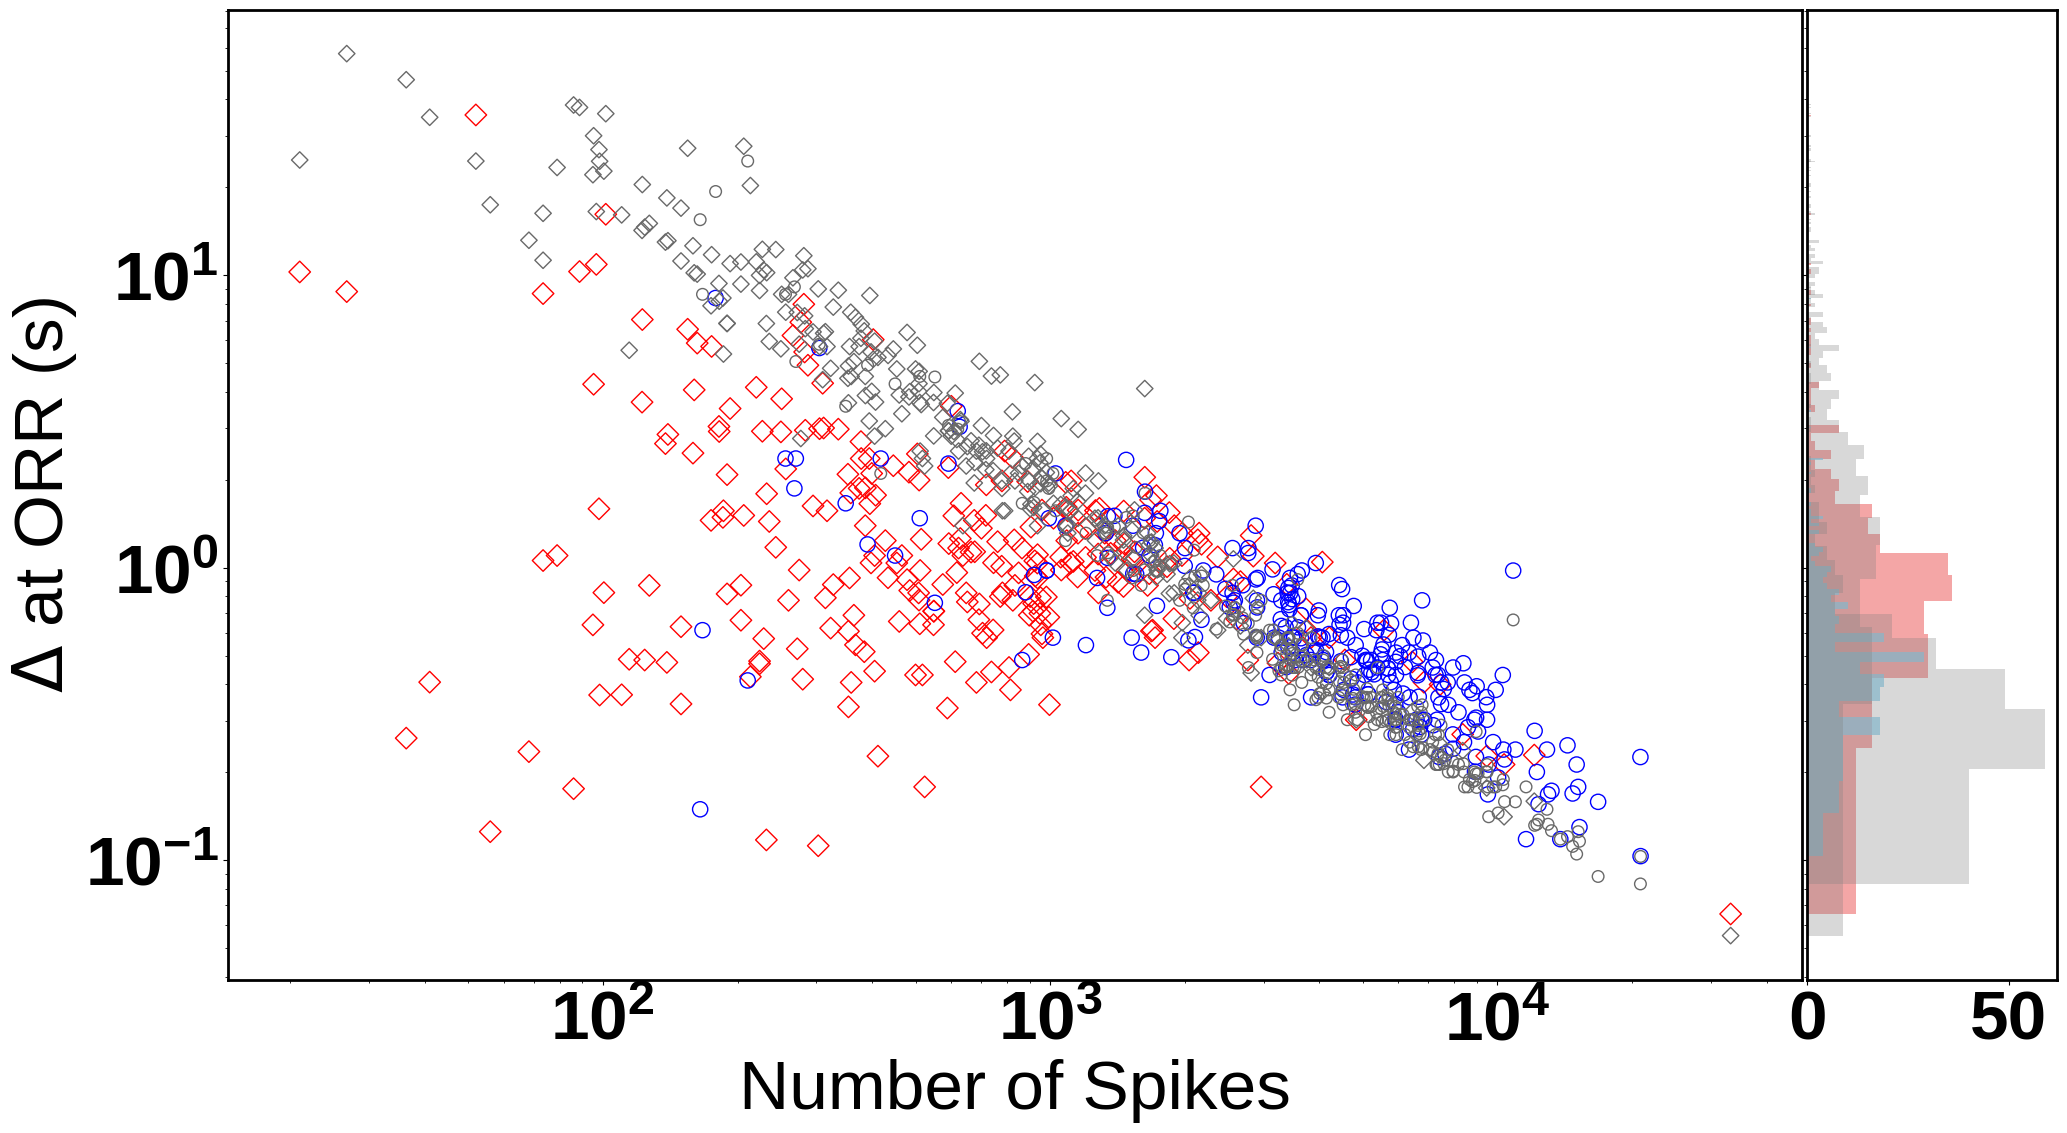

In [14]:
# Create scatter plot
fig, ax = plt.subplots()
quant='dt_OHK'
quant_lab=r'$\Delta$ at ORR (s)'
figname='../figures/DeltaORRvNspikes.pdf'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig1B.png'

#msr1F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,6],fill_value="extrapolate")
#msr2F = interpolate.interp1d(np.log(optimal[:,0]), optimal[:,1],fill_value="extrapolate")

# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')[quant], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')[quant], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['Nspikes'], df.query('LOC=="CA1"')['poss_'+quant], label='rand. CA1 Neurons', marker='D', facecolors='none',edgecolors='dimgrey',s=mss-50)
ax.scatter(df.query('LOC=="SUB"')['Nspikes'], df.query('LOC=="SUB"')['poss_'+quant], label='rand. SUB Neurons', marker='o', facecolors='none',edgecolors='dimgrey',s=mss-50)
# #Line plot for optimal 
# ax.plot(df['Nspikes'].sort_values(), msr1F(np.log(np.array(df['Nspikes'].sort_values()))),'-.',color='tab:orange', linewidth=3,label='optimal')
# ax.plot(df['Nspikes'].sort_values(), msr2F(np.log(np.array(df['Nspikes'].sort_values()))),'--',color='tab:brown', linewidth=3,label='rand. optimal')

# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.05, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 200
ax_histy.hist(df.query('LOC=="CA1"')[quant], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quant], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quant], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel('Number of Spikes')
ax.set_ylabel(quant_lab)  # Adjusted Y-axis label
ax.set_xscale('log');ax.set_yscale('log');
# ax.set_ylim(0.1, 0.7)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
for tick in ax_histy.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.16), ncol=3,fontsize=22)

# plt.tight_layout()
plt.savefig(figname,bbox_inches='tight',dpi=300)
#plt.savefig(figname2,dpi=300)
plt.show(fig)

In [15]:
import plotly.express as px


px.scatter(data_frame=df, x='Nspikes', y=['MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["RatID","task"],marginal_y='histogram',template='simple_white')

#px.scatter(data_frame=data, x='Nspikes', y=['MSR','poss_MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')

In [16]:
# px.scatter(data_frame=data, x='Nspikes', y=['MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')